# Drought in Madagascar 

The third notebook in this section, is an in-depth analysis of the recent drought that has impacted the island of Madagascar.

Monitoring drought in Madagascar, particularly in its southern regions, is crucial due to the significant impact on the local environment and communities. The island nation, located off the southeast coast of Africa, often faces periods of severe drought, which can drastically affect its agricultural productivity and food security.

Environmental and climatic data are used to monitor drought. Rainfall patterns, soil moisture levels, and temperature variations are all critical factors in assessing drought severity. These data help in understanding the underlying causes of drought and predicting future trends.

The impact of drought in Madagascar extends beyond agriculture. It affects water availability, health, and overall livelihoods of the local population. Therefore, continuous monitoring and analysis are necessary to develop effective mitigation and adaptation strategies. This comprehensive approach enables stakeholders, including government agencies and international organizations, to respond promptly and effectively to drought conditions, minimizing their adverse effects on the population and the environment.

This is an example of the type of analysis you can conduct once you’ve retrieved the coordinates of your area of interest, and this will be particularly significant when we reach the third phase of our journey, where we’ll explore the drivers of drought.

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import numpy as np

In [2]:
def get_spi_dataset(acc_period: str = 1, years: list = [2020]):
    data_root_folder = '/data1/drought_dataset/spi/'
    spi_folder = os.path.join(data_root_folder, f'spi{acc_period}')
    spi_paths = []

    for year in years:
        spi_paths.extend(sorted(glob.glob(
            f'{data_root_folder}spi{acc_period}/SPI{acc_period}_gamma_global_era5_moda_ref1991to2020_{year}*.nc')))

    return xr.open_mfdataset(spi_paths, chunks={'time': "auto"}, concat_dim="time", combine='nested', parallel=False)


def get_spei_dataset(acc_period: str = 1, years: list = [2020]):
    data_root_folder = '/data1/drought_dataset/spei/'
    spi_folder = os.path.join(data_root_folder, f'spi{acc_period}')
    spi_paths = []

    for year in years:
        spi_paths.extend(sorted(glob.glob(
            f'{data_root_folder}spei{acc_period}/SPEI{acc_period}_genlogistic_global_era5_moda_ref1991to2020_{year}*.nc')))

    return xr.open_mfdataset(spi_paths, chunks={'time': "auto"}, concat_dim="time", combine='nested', parallel=False)


def mask_invalid_values(ds, variable, value=-9999):
    ds[variable] = ds[variable].where(ds[variable] != value, np.nan)
    return ds


def subset_madagascar(dataset, variable):
    # data = dataset.sel(time=np.datetime64(time), method='nearest')[variable]

    # Define the geographical boundaries for Madagascar
    lat_bounds = [-26.8, -9.95]  # from south to north
    lon_bounds = [40.23, 52.45]  # from west to east

    # Check for NaN values in latitude and longitude coordinates
    lat_nan = dataset['lat'].isnull().any()
    lon_nan = dataset['lon'].isnull().any()

    # Handle NaN values if they exist
    if lat_nan:
        dataset = dataset.dropna(dim='lat', how='all')
    if lon_nan:
        dataset = dataset.dropna(dim='lon', how='all')

    # Ensure no NaN values in the data itself
    dataset = dataset.fillna(np.nan)  # or use another appropriate method like interpolation

    # Ensure the lat/lon bounds are within the data's range
    lat_min, lat_max = dataset['lat'].min().item(), dataset['lat'].max().item()
    lon_min, lon_max = dataset['lon'].min().item(), dataset['lon'].max().item()

    if lat_bounds[0] < lat_min or lat_bounds[1] > lat_max or lon_bounds[0] < lon_min or lon_bounds[1] > lon_max:
        raise ValueError("The specified latitude/longitude bounds are outside the range of the dataset.")

    # Subset the data using where and dropna
    dataset = dataset.where(
        (dataset['lat'] >= lat_bounds[0]) & (dataset['lat'] <= lat_bounds[1]) &
        (dataset['lon'] >= lon_bounds[0]) & (dataset['lon'] <= lon_bounds[1]),
        drop=True
    )

    # return xr.Dataset(data)
    return dataset

In [3]:
def get_spei_significance_dataset(variable='SPEI1', year=2020):
    data_root_folder='/data1/drought_dataset/spei/'
    quality_paths = []
    for month in range(1, 13):
        month_str = f'{month:02d}'
        quality_paths.append(f'{data_root_folder}{variable.lower()}/parameter/{variable}_significance_global_era5_moda_{year}{month_str}_ref1991to2020.nc')
    return xr.open_mfdataset(quality_paths, concat_dim="time", combine='nested', parallel=False)

def get_spi_significance_dataset(variable='SPI1', year=2020):
    data_root_folder='/data1/drought_dataset/spi/'
    quality_paths = []
    for month in range(1, 13):
        month_str = f'{month:02d}'
        quality_paths.append(f'{data_root_folder}{variable.lower()}/parameter/{variable}_significance_global_era5_moda_{year}{month_str}_ref1991to2020.nc')
    return xr.open_mfdataset(quality_paths, concat_dim="time", combine='nested', parallel=False)

In [4]:
spi1 = get_spi_dataset(acc_period=1, years=[2016, 2017, 2018, 2019, 2020])
spi12 = get_spi_dataset(acc_period=12, years=[2016, 2017, 2018, 2019, 2020])
spei1 = get_spei_dataset(acc_period=1, years=[2016, 2017, 2018, 2019, 2020])
spei12 = get_spei_dataset(acc_period=12, years=[2016, 2017, 2018, 2019, 2020])

# Subset data for Madagascar
spi1_madagascar = mask_invalid_values(subset_madagascar(spi1, variable='SPI1'), variable='SPI1')
spi12_madagascar = mask_invalid_values(subset_madagascar(spi12, variable='SPI12'), variable='SPI12')
spei1_madagascar = mask_invalid_values(subset_madagascar(spei1, variable='SPEI1'), variable='SPEI1')
spei12_madagascar = mask_invalid_values(subset_madagascar(spei12, variable='SPEI12'), variable='SPEI12')

spei1_significance = get_spei_significance_dataset(year=2020)
spi1_significance = get_spi_significance_dataset(year=2020)

spei1_significance_madagascar = mask_invalid_values(subset_madagascar(spei1_significance, variable='significance'), variable='significance', value=0.)
spi1_significance_madagascar = mask_invalid_values(subset_madagascar(spi1_significance, variable='significance'), variable='significance', value=0.)

In [5]:
spei1_significance_madagascar.significance.sel(time=f'{2020}-{1 + 1:02d}', method='nearest')

<xarray.DataArray 'significance' (lat: 68, lon: 49)> Size: 27kB
dask.array<getitem, shape=(68, 49), dtype=float64, chunksize=(68, 49), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2020-02-01
  * lon      (lon) float64 392B 40.25 40.5 40.75 41.0 ... 51.5 51.75 52.0 52.25
  * lat      (lat) float64 544B -10.0 -10.25 -10.5 ... -26.25 -26.5 -26.75
Attributes:
    units:    -

In [6]:
spei1_madagascar.SPEI1.sel(time=f'{2020}-{1 + 1:02d}', method='nearest')

<xarray.DataArray 'SPEI1' (lat: 68, lon: 49)> Size: 27kB
dask.array<getitem, shape=(68, 49), dtype=float64, chunksize=(68, 49), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2020-02-01T06:00:00
  * lon      (lon) float64 392B 40.25 40.5 40.75 41.0 ... 51.5 51.75 52.0 52.25
  * lat      (lat) float64 544B -10.0 -10.25 -10.5 ... -26.25 -26.5 -26.75
Attributes:
    long_name:  Standardized Drought Index (SPEI1)
    units:      -

Text(0.5, 1.0, 'SPEI12 for December 2020')

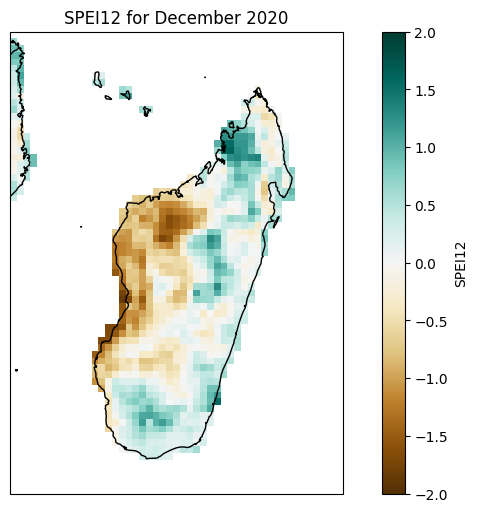

In [7]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
spei12_madagascar.sel(time='2017-12').SPEI12.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-2, vmax=2,
                                                cbar_kwargs={'label': 'SPEI12'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('SPEI12 for December 2020')

In [8]:
def plot_spei1_annual(spei1, year):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]
    for i, ax in enumerate(axes.flatten()):
        spei1.SPEI1.sel(time=f'{year}-{i + 1:02d}', method='nearest').plot(ax=ax, transform=ccrs.PlateCarree(),
                                                                         cmap='BrBG', vmin=-3, vmax=3,
                                                                         cbar_kwargs={'label': 'SPEI1'})
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.set_title(f'SPEI1 for {months[i]} {year}')
    fig.tight_layout()
    plt.show()

def plot_spi1_annual(spi1, year):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]
    for i, ax in enumerate(axes.flatten()):
        spi1.SPI1.sel(time=f'{year}-{i + 1:02d}', method='nearest').plot(ax=ax, transform=ccrs.PlateCarree(),
                                                                         cmap='BrBG', vmin=-3, vmax=3,
                                                                         cbar_kwargs={'label': 'SPI1'})
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.set_title(f'SPI1 for {months[i]} {year}')
    fig.tight_layout()
    plt.show()

## Significance

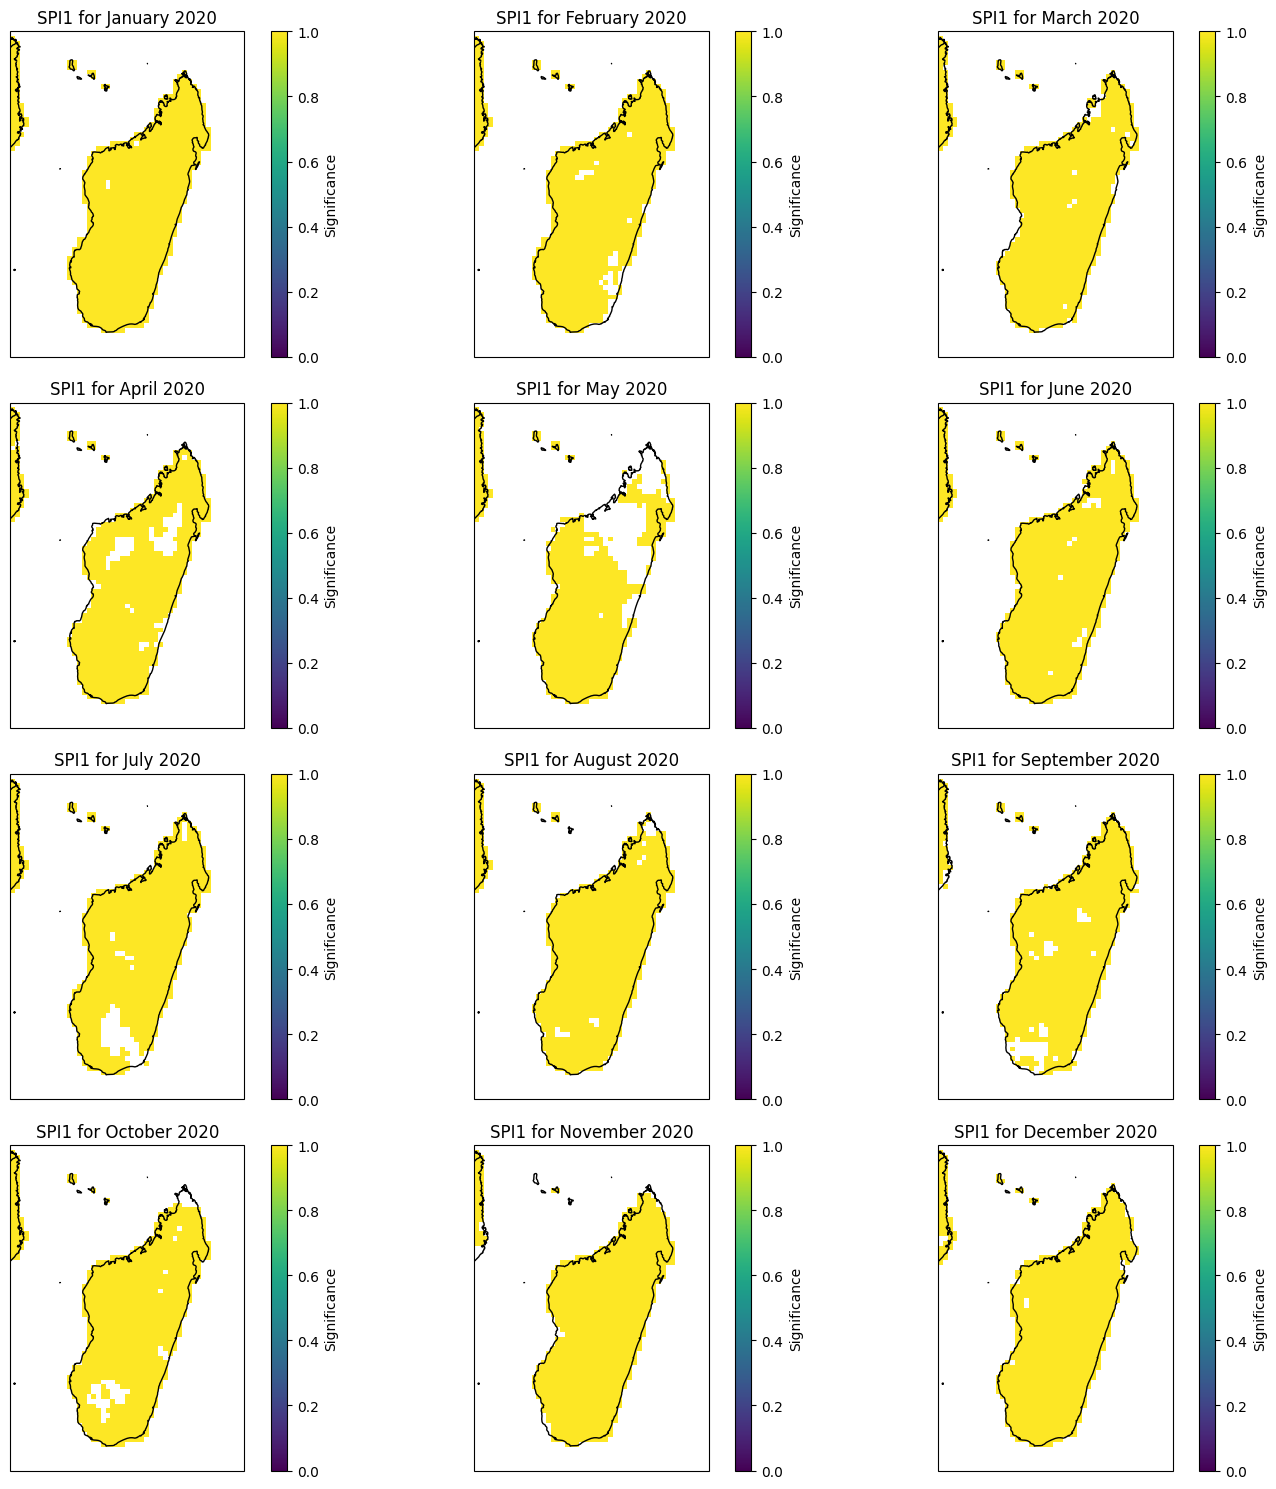

In [9]:
year = 2020
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
for i, ax in enumerate(axes.flatten()):
    spei1_significance_madagascar.significance.sel(time=f'{year}-{i + 1:02d}', method='nearest').plot(ax=ax, transform=ccrs.PlateCarree(),
                                                                     vmin=0, vmax=1,
                                                                     cbar_kwargs={'label': 'Significance'})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(f'SPI1 for {months[i]} {year}')
fig.tight_layout()
plt.show()


## Monthly SPEI with masked significance

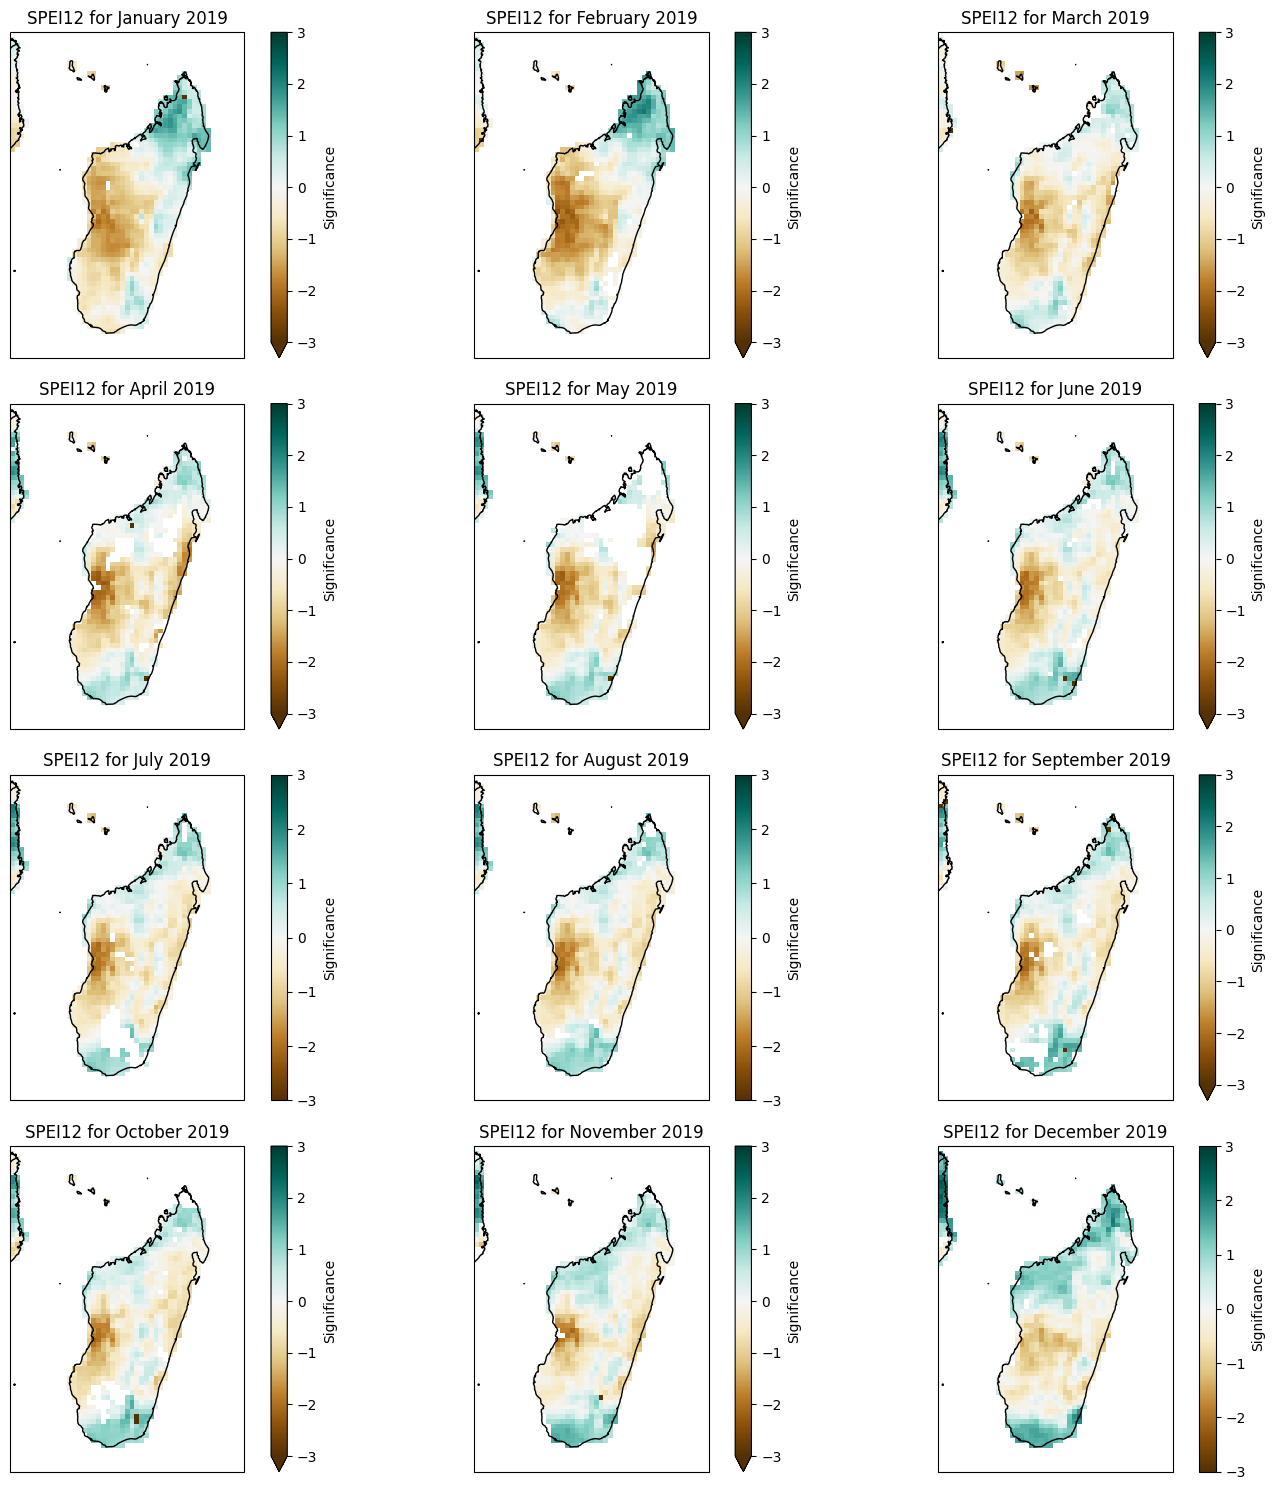

In [10]:
year = 2019
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
months = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]
for i, ax in enumerate(axes.flatten()):
    (spei12_madagascar.SPEI12.sel(time=f'{year}-{i + 1:02d}', method='nearest') * spei1_significance_madagascar.significance.sel(time=f'{2020}-{i + 1:02d}', method='nearest')).plot(ax=ax, transform=ccrs.PlateCarree(),cmap='BrBG', vmin=-3, vmax=3,cbar_kwargs={'label': 'Significance'})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(f'SPEI12 for {months[i]} {year}')
fig.tight_layout()
plt.show()

## Monthly SPEI

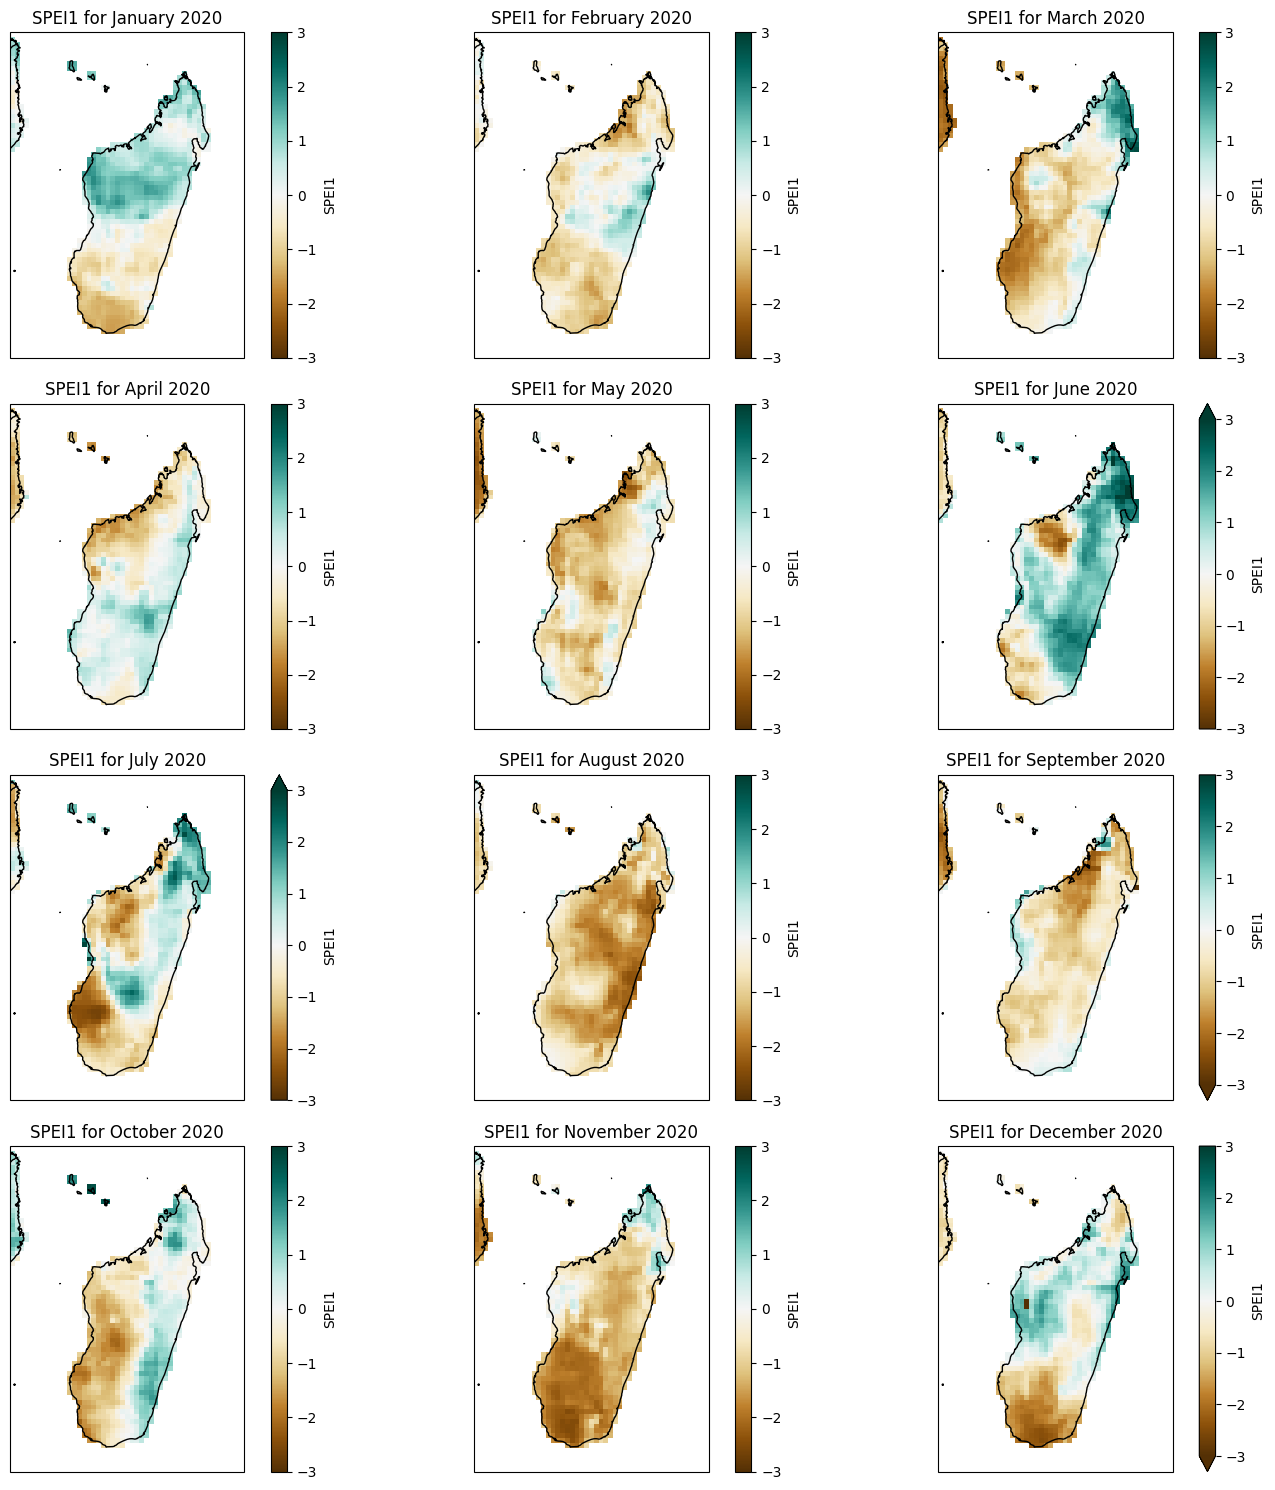

In [11]:
plot_spei1_annual(spei1_madagascar, year=2020)

## SPI12

Text(0.5, 1.0, 'SPI12 for December 2020')

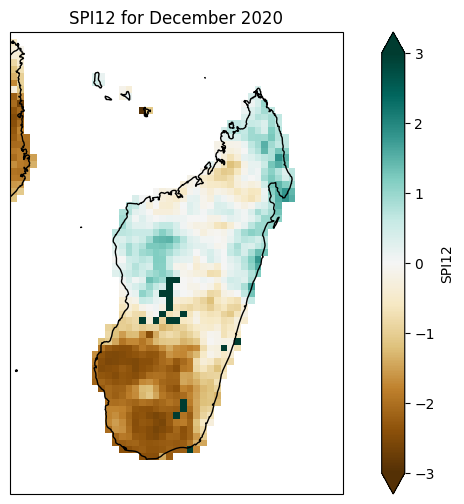

In [12]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
spi12_madagascar.sel(time='2020-12').SPI12.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-3, vmax=3,
                                                cbar_kwargs={'label': 'SPI12'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('SPI12 for December 2020')

## Monthly SPI1

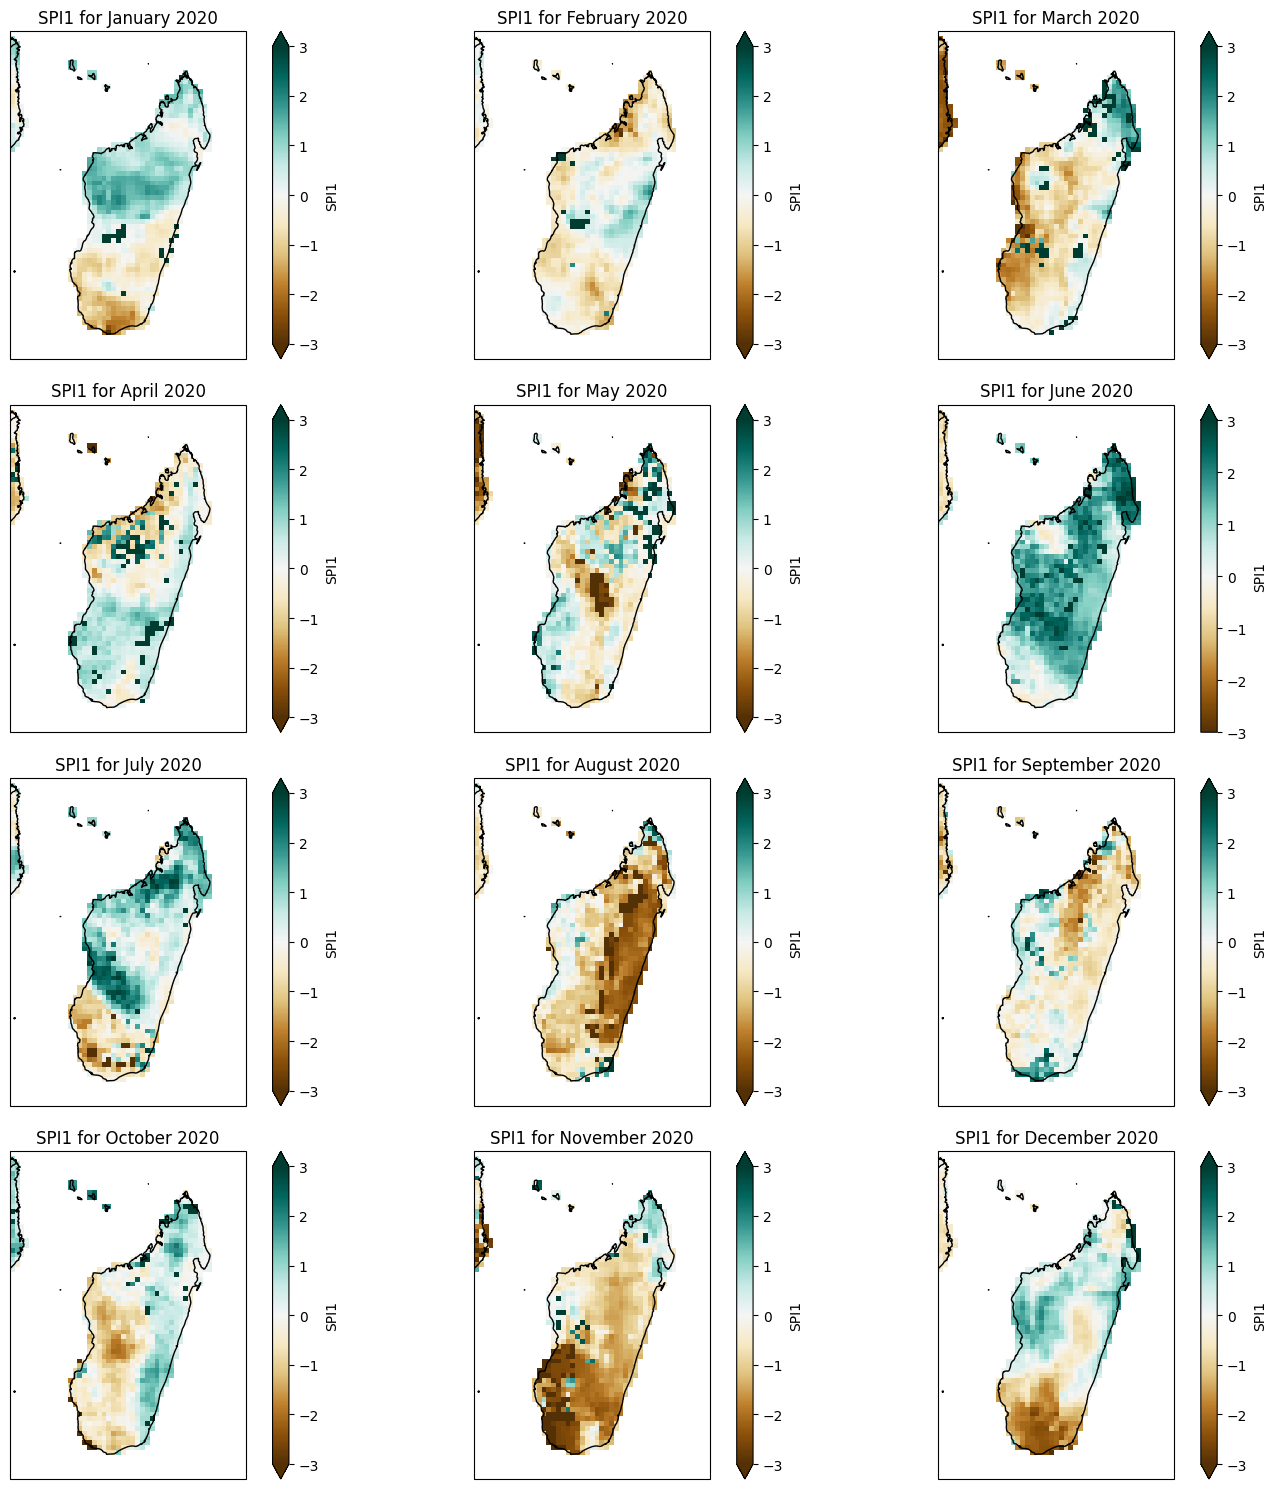

In [13]:
plot_spi1_annual(spi1_madagascar, year=2020)

## Monthly SPI with masked significance

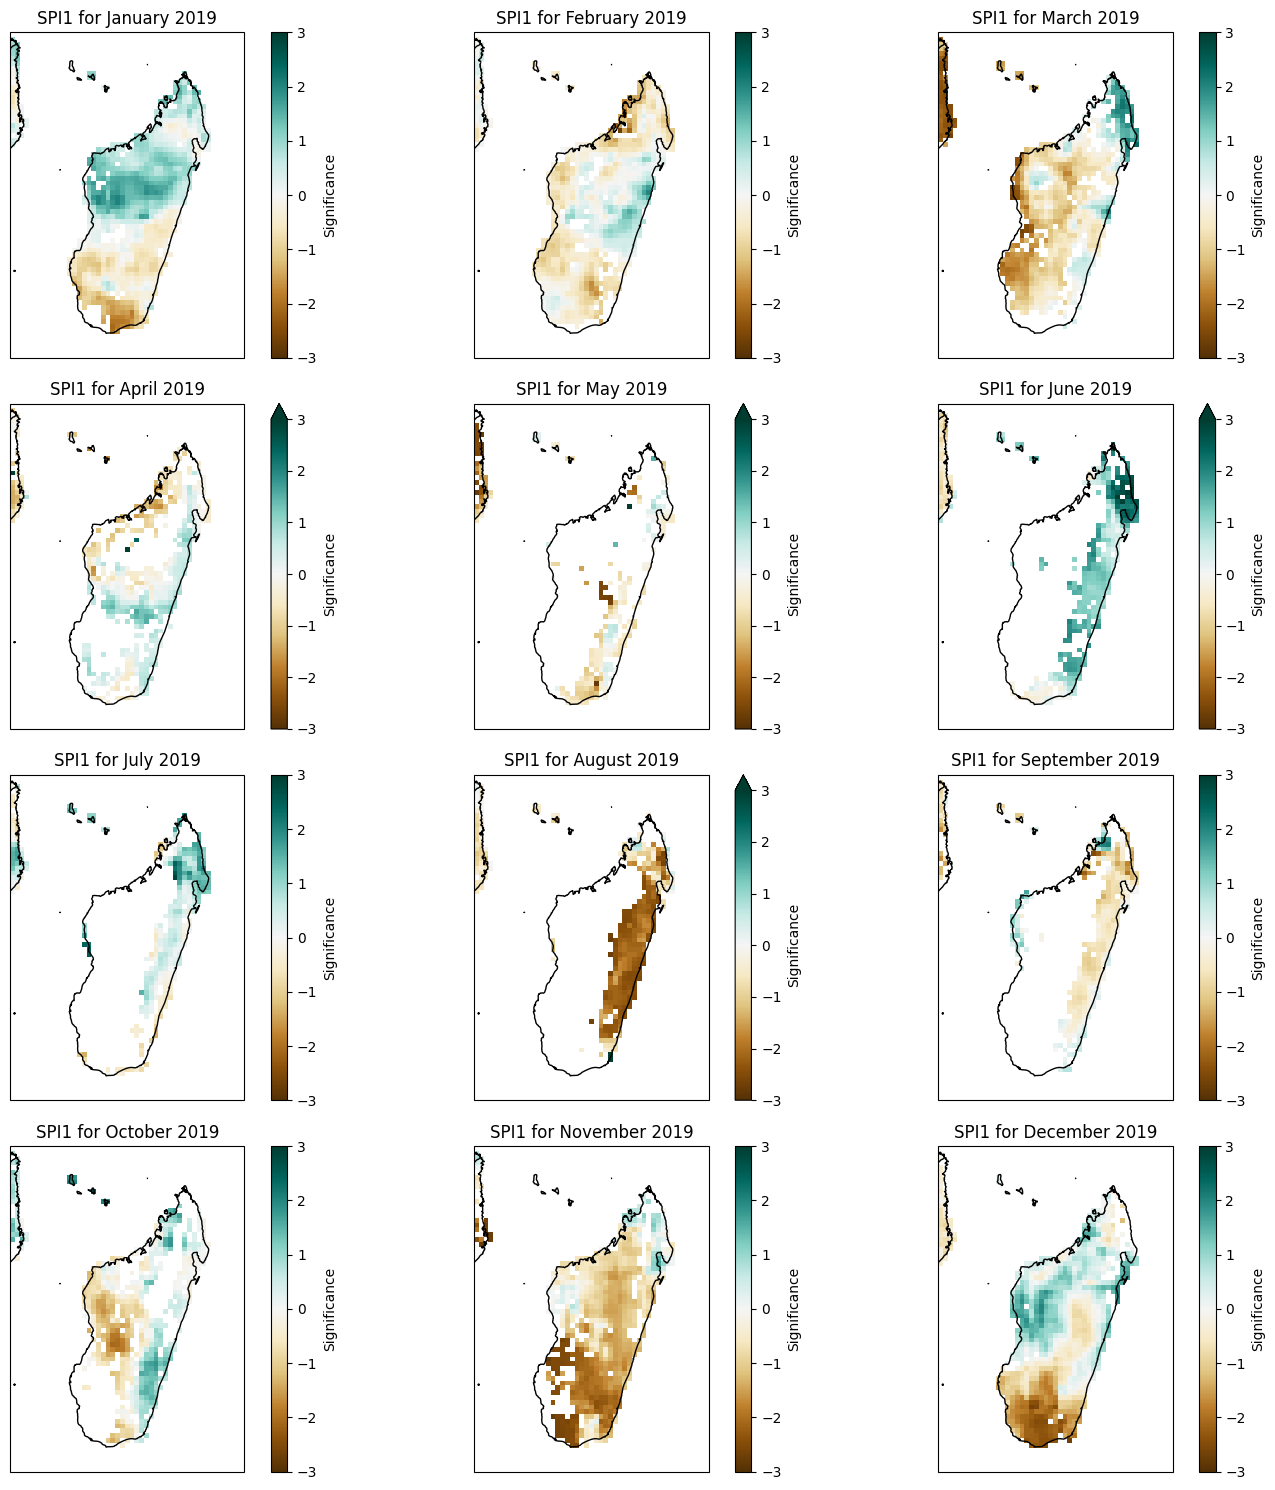

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
months = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]
for i, ax in enumerate(axes.flatten()):
    (spi1_madagascar.SPI1.sel(time=f'{2020}-{i + 1:02d}', method='nearest') * spi1_significance_madagascar.significance.sel(time=f'{2020}-{i + 1:02d}', method='nearest')).plot(ax=ax, transform=ccrs.PlateCarree(),cmap='BrBG', vmin=-3, vmax=3,cbar_kwargs={'label': 'Significance'})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(f'SPI1 for {months[i]} {year}')
fig.tight_layout()
plt.show()

## Resources


- https://earthobservatory.nasa.gov/images/148636/drought-in-madagascar
- https://news.un.org/en/story/2021/07/1096482
- https://iopscience.iop.org/article/10.1088/2752-5295/aca695/pdf
- https://www.nature.com/articles/s41612-024-00583-8
- https://www.sciencedirect.com/science/article/pii/S1674987119302324
- https://www.researchgate.net/profile/Moustapha-Tall-2/publication/375278797_Drought_variability_changes_and_hot_spots_across_the_African_continent_during_the_historical_period_1928-2017/links/654541913fa26f66f4d278e3/Drought-variability-changes-and-hot-spots-across-the-African-continent-during-the-historical-period-1928-2017.pdf